# Практические задания к лекции № 6

In [68]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve

%matplotlib inline
import matplotlib.pylab as plt

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [43]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [44]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [45]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [46]:
enc_features = ['Geography', 'Gender']

In [47]:
enc = OrdinalEncoder()
df[enc_features] = enc.fit_transform(df[enc_features])

In [48]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.0,0.0,42,2,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8,159660.80,3,1,0,113931.57,1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Exited'], random_state=28)

In [9]:
model = RandomForestClassifier(random_state=28)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [11]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:
f1: 55.88%
roc: 70.54%
recall: 45.01%
precision: 73.67%


In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=1.000000, F-Score=0.559, Precision=0.737, Recall=0.450


**Тюнинг модели**

In [19]:
parameters = {
    'max_depth': [1, 3, 5, 7, 10, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [0.3, 0.5, 0.7, 1.],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'random_state': [28]
}

In [20]:
clf = GridSearchCV(RandomForestClassifier(), parameters, scoring='f1', n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'max_depth': [1, 3, 5, 7, 10, None],
                         'max_features': [0.3, 0.5, 0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'random_state': [28]},
             scoring='f1')

In [21]:
clf.best_score_

0.6217708071296876

In [22]:
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'max_features': 0.3,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'random_state': 28}

In [23]:
model_tune = RandomForestClassifier(**clf.best_params_)

model_tune.fit(X_train, y_train)
y_predict = model_tune.predict(X_test)

In [24]:
evaluate_results(y_test, y_predict)

Classification results:
f1: 61.01%
roc: 76.66%
recall: 65.17%
precision: 57.35%


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=1.000000, F-Score=0.610, Precision=0.573, Recall=0.652


#### random negative sampling
Представим, что нам неизвестны негативы и часть позитивов

In [26]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 510/2037 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [27]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    9490
 1     510
Name: class_test, dtype: int64


In [28]:
mod_data.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,class_test
0,619,0.0,0.0,42,2,0.00,1,1,1,101348.88,1,-1
1,608,2.0,0.0,41,1,83807.86,1,0,1,112542.58,0,-1
2,502,0.0,0.0,42,8,159660.80,3,1,0,113931.57,1,1
3,699,0.0,0.0,39,1,0.00,2,0,0,93826.63,0,-1
4,850,2.0,0.0,43,2,125510.82,1,1,1,79084.10,0,-1
5,645,2.0,1.0,44,8,113755.78,2,1,0,149756.71,1,-1
6,822,0.0,1.0,50,7,0.00,2,1,1,10062.80,0,-1
7,376,1.0,0.0,29,4,115046.74,4,1,0,119346.88,1,-1
8,501,0.0,1.0,44,4,142051.07,2,0,1,74940.50,0,-1
9,684,0.0,1.0,27,2,134603.88,1,1,1,71725.73,0,-1


In [30]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(510, 12) (510, 12)


In [31]:
model_tune.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict_RNS = model_tune.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict_RNS)

Classification results:
f1: 48.81%
roc: 76.53%
recall: 82.60%
precision: 34.64%


In [33]:
precision, recall, thresholds = precision_recall_curve(sample_test.iloc[:,-2].values, y_predict_RNS)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=1.000000, F-Score=0.488, Precision=0.346, Recall=0.826


**7. сравнить качество с решением из пункта 4**

In [80]:
evaluate_results(y_test, y_predict)

Classification results:
f1: 61.01%
roc: 76.66%
recall: 65.17%
precision: 57.35%


Полнота возрасла, но f1 значительно просела за счёт уменьшения точности. В принципе исходя из условий задачи из предыдущего ДЗ, нам как раз нужно максимизировать полноту (чтобы не тратить деньги на ложноположительных клиентов) и эта модель лучше.

**8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)**

In [65]:
def RNS(data, model=RandomForestClassifier(), p=0.25):
    mod_data = data.copy()
    #get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)
    # leave just 25% of the positives marked
    pos_sample_len = int(np.ceil(p * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]
    
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    
#     x_data = mod_data.iloc[:,:-2].values # just the X 
#     y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
#     y_positive = mod_data.iloc[:,-2].values # original class
    
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    model.fit(sample_train.iloc[:,:-2].values, sample_train.iloc[:,-2].values)
    y_predict_RNS = model_tune.predict(sample_test.iloc[:,:-2].values)
    f1 = f1_score(sample_test.iloc[:,-2].values, y_predict_RNS)
    roc_auc = roc_auc_score(sample_test.iloc[:,-2].values, y_predict_RNS)
    return f1, roc_auc

In [78]:
f1 = []
roc_auc = []
p = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for p_val in p:
    scores = RNS(df, model_tune, p_val)
    f1.append(scores[0])
    roc_auc.append(scores[1])

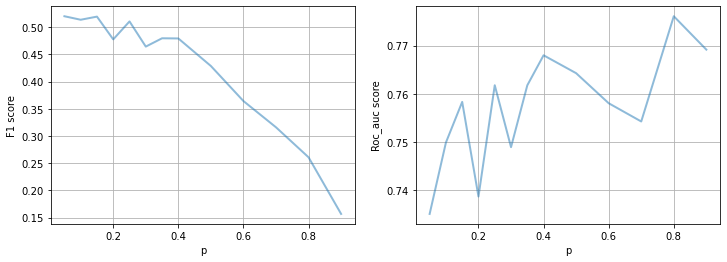

In [79]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(p, f1, linewidth=2, alpha=0.5)
ax1.set_ylabel('F1 score')
ax1.set_xlabel('p')
plt.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(p, roc_auc, linewidth=2, alpha=0.5)
ax2.set_ylabel('Roc_auc score')
ax2.set_xlabel('p')
plt.grid()


Тенденция следующая: с увеличением доли P, f1 score уменьшается, а roc_auc увеличивается. Связано это, скорее всего, с тем, что у нас дисбаланс классов, и точность при увеличении P падает, тогда как полнота растёт, а метрика f1 чувствительнее к точности и полноте.